<a href="https://colab.research.google.com/github/brieueu/Projetos_Machine_Learning/blob/main/Cria%C3%A7%C3%A3o_de_um_classificador_de_previs%C3%A3o_de_chuvas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Criação de um classificador de previsão de chuvas
### Projeto final do curso: Aprendizagem automática com Python
Disponível em: https://www.coursera.org/learn/machine-learning-with-python

## Objetivos:
* Explorar e realizar engenharia de atributos em um conjunto de dados do mundo real

* Construir um pipeline de classificação e otimizá-lo usando validação cruzada com busca em grade

* Avaliar seu modelo interpretando várias métricas de desempenho e visualizações

* Implementar um classificador diferente atualizando seu pipeline

* Utilizar um conjunto apropriado de parâmetros para realizar a busca em cada caso


# Sobre o Dataser

A fonte original dos dados é o Bureau of Meteorology do Governo Australiano, e os dados mais recentes podem ser obtidos em http://www.bom.gov.au/climate/dwo/
.

O conjunto de dados utilizados neste projeto foi baixado do Kaggle em https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package/ .
As definições das colunas foram obtidas em http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml
.

O conjunto de dados contém observações de métricas meteorológicas para cada dia de 2008 a 2017 e inclui os seguintes campos:


| Campo         | Descrição                                             | Unidade         | Tipo   |
| :------------ | :---------------------------------------------------- | :-------------- | :----- |
| Date          | Data da observação no formato AAAA-MM-DD              | Data            | object |
| Location      | Local da observação                                   | Localização     | object |
| MinTemp       | Temperatura mínima                                    | Celsius         | float  |
| MaxTemp       | Temperatura máxima                                    | Celsius         | float  |
| Rainfall      | Quantidade de precipitação                            | Milímetros      | float  |
| Evaporation   | Quantidade de evaporação                              | Milímetros      | float  |
| Sunshine      | Quantidade de luz solar direta                        | Horas           | float  |
| WindGustDir   | Direção da rajada de vento mais forte                 | Pontos cardeais | object |
| WindGustSpeed | Velocidade da rajada de vento mais forte              | Km/h            | object |
| WindDir9am    | Direção do vento (média de 10 min antes das 9h)       | Pontos cardeais | object |
| WindDir3pm    | Direção do vento (média de 10 min antes das 15h)      | Pontos cardeais | object |
| WindSpeed9am  | Velocidade do vento (média de 10 min antes das 9h)    | Km/h            | float  |
| WindSpeed3pm  | Velocidade do vento (média de 10 min antes das 15h)   | Km/h            | float  |
| Humidity9am   | Umidade relativa às 9h                                | Porcentagem     | float  |
| Humidity3pm   | Umidade relativa às 15h                               | Porcentagem     | float  |
| Pressure9am   | Pressão atmosférica ao nível do mar às 9h             | Hectopascal     | float  |
| Pressure3pm   | Pressão atmosférica ao nível do mar às 15h            | Hectopascal     | float  |
| Cloud9am      | Fração do céu coberta por nuvens às 9h                | Oitavos         | float  |
| Cloud3pm      | Fração do céu coberta por nuvens às 15h               | Oitavos         | float  |
| Temp9am       | Temperatura às 9h                                     | Celsius         | float  |
| Temp3pm       | Temperatura às 15h                                    | Celsius         | float  |
| RainToday     | Indica se choveu ao menos 1mm no dia observado        | Sim/Não         | object |
| RainTomorrow  | Indica se choverá ao menos 1mm no dia seguinte        | Sim/Não         | object |


# Baixando Biliotecas

Primeiro, vamos baixar as bibliotecas necessárias para o projeto.

In [16]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn

# Importando Bibliotecas

Agora, vamos importar as bibliotecas que usaremos para análise, pré-processamento e modelagem.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Carregando dados

* Carregamos os dados.

* Vimos que há muitas faltas em algumas colunas.

* Decidimos remover linhas com valores ausentes.

* Restam 56 mil linhas, o que ainda é suficiente. Mas é preciso cuidado para não usar informações que só estariam disponíveis depois do dia da previsão, senão o modelo ficaria “irrealisticamente bom”.

In [3]:
url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/_0eYOqji3unP1tDNKWZMjg/weatherAUS-2.csv"
df = pd.read_csv(url)
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [8]:
df.count()

,0
Date,145460
Location,145460
MinTemp,143975
MaxTemp,144199
Rainfall,142199
Evaporation,82670
Sunshine,75625
WindGustDir,135134
WindGustSpeed,135197
WindDir9am,134894


In [9]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56420 entries, 6049 to 142302
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           56420 non-null  object 
 1   Location       56420 non-null  object 
 2   MinTemp        56420 non-null  float64
 3   MaxTemp        56420 non-null  float64
 4   Rainfall       56420 non-null  float64
 5   Evaporation    56420 non-null  float64
 6   Sunshine       56420 non-null  float64
 7   WindGustDir    56420 non-null  object 
 8   WindGustSpeed  56420 non-null  float64
 9   WindDir9am     56420 non-null  object 
 10  WindDir3pm     56420 non-null  object 
 11  WindSpeed9am   56420 non-null  float64
 12  WindSpeed3pm   56420 non-null  float64
 13  Humidity9am    56420 non-null  float64
 14  Humidity3pm    56420 non-null  float64
 15  Pressure9am    56420 non-null  float64
 16  Pressure3pm    56420 non-null  float64
 17  Cloud9am       56420 non-null  float64
 18  Cloud3p

In [10]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [11]:
df = df.rename(columns={'RainToday': 'RainYesterday',
                        'RainTomorrow': 'RainToday'
                        })

Ainda temos 7557 registros, o que deve ser suficiente para construir um modelo razoavelmente bom.

# Extraindo características de sazonalidade

Agora, consideramos a coluna `Date`. Esperamos que os padrões climáticos sejam sazonais, apresentando diferentes níveis de previsibilidade no inverno e no verão, por exemplo.

Pode haver alguma variação também com o `Year`, mas por enquanto vamos deixar isso de lado.

Vamos criar uma nova característica chamada `Season` a partir de `Date` e depois remover `Date`, já que provavelmente ela é menos informativa do que a estação.

Uma maneira simples de fazer isso é definir uma função que atribua estações aos meses e, em seguida, usar essa função para transformar a coluna `Date`.

In [12]:
def date_to_season(date):
    month = date.month
    if (month == 12) or (month == 1) or (month == 2):
        return 'Summer'
    elif (month == 3) or (month == 4) or (month == 5):
        return 'Autumn'
    elif (month == 6) or (month == 7) or (month == 8):
        return 'Winter'
    elif (month == 9) or (month == 10) or (month == 11):
        return 'Spring'

## Função para mapear mês -> estação

Vamos definir uma função que mapeia o número do mês para a estação correspondente no hemisfério sul.

In [14]:
def date_to_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Summer'   # Verão (no hemisfério sul)
    elif month in [3, 4, 5]:
        return 'Autumn'   # Outono
    elif month in [6, 7, 8]:
        return 'Winter'   # Inverno
    else:
        return 'Spring'   # Primavera

df['Date'] = pd.to_datetime(df['Date'])

df['Season'] = df['Date'].apply(date_to_season)

df = df.drop(columns=['Date'])

df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainYesterday,RainToday,Season
6049,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,SW,...,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No,Summer
6050,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,SSE,...,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No,Summer
6052,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,NNW,...,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No,Summer
6053,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,WSW,...,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No,Summer
6054,Cobar,24.2,41.0,0.0,11.2,8.4,WNW,35.0,NW,WNW,...,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No,No,Summer


In [15]:
X = df.drop(columns='RainToday', axis=1)
y = df['RainToday']

## Verificando o balanceamento das classes

Vamos verificar a distribuição das classes na variável alvo para entender se o conjunto de dados é balanceado. Isso é importante para a escolha de métricas de avaliação adequadas.

In [18]:
display(y.value_counts())

,count
RainToday,
No,43993
Yes,12427


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [20]:
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

In [22]:
# Scale the numeric features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode the categoricals
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [23]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [24]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [25]:
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

# Execute a validação cruzada da pesquisa em grade e ajuste o melhor modelo aos dados de treinamento

In [26]:
cv = StratifiedKFold(n_splits=5, shuffle=True)

## Obtendo as previsões do modelo no conjunto de teste

Vamos usar o melhor modelo encontrado pelo `GridSearchCV` para fazer previsões no conjunto de teste.

In [28]:
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=  18.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=  19.2s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=  18.3s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=  19.4s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=  20.2s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=  37.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=  39.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MinTemp',
                                                                          'MaxTemp',
                                                                          'Rainfall',
                                                                          'Evaporation',
                                                                          'Sunshine',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Pr...
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Location',
                                                                          'WindGustDir',
                                                                          'WindDir9am',
                                                                          'WindDir3pm',
                                                                          'RainYesterday',
                                                                          'Season'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [50, 100]},
             scoring='accuracy', verbose=2)

In [31]:
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Best parameters found:  {'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best cross-validation score: 0.86


In [32]:
test_score = grid_search.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))

Test set score: 0.86


In [33]:
y_pred = grid_search.predict(X_test)

In [34]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

          No       0.88      0.96      0.92      8799
         Yes       0.78      0.52      0.62      2485

    accuracy                           0.86     11284
   macro avg       0.83      0.74      0.77     11284
weighted avg       0.85      0.86      0.85     11284



## Plotando a matriz de confusão

Vamos plotar a matriz de confusão para visualizar o número de verdadeiros positivos, verdadeiros negativos, falsos positivos e falsos negativos.

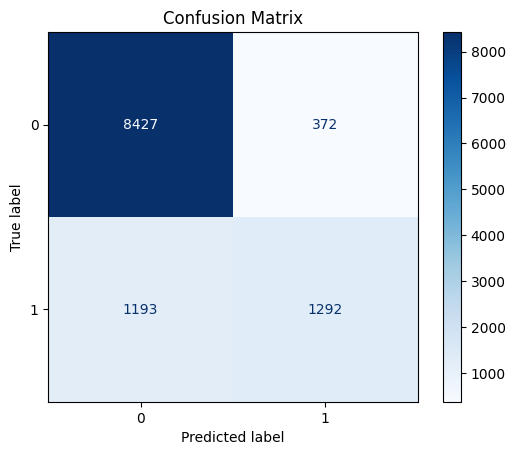

In [35]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [36]:
feature_importances = grid_search.best_estimator_['classifier'].feature_importances_

# Exibindo as características mais importantes

Vamos combinar os nomes das características (numéricas e categóricas após one-hot encoding) com suas importâncias e exibir as N características mais importantes em um gráfico.

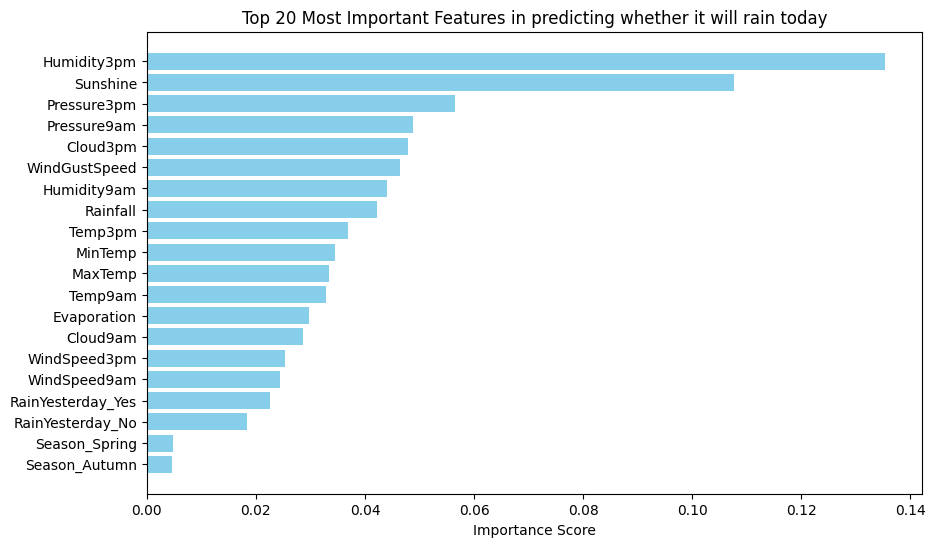

In [37]:
# Combine numeric and categorical feature names
feature_names = numeric_features + list(grid_search.best_estimator_['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['onehot']
                                        .get_feature_names_out(categorical_features))

feature_importances = grid_search.best_estimator_['classifier'].feature_importances_

importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances
                             }).sort_values(by='Importance', ascending=False)

N = 20  # Change this number to display more or fewer features
top_features = importance_df.head(N)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.title(f'Top {N} Most Important Features in predicting whether it will rain today')
plt.xlabel('Importance Score')
plt.show()

# Treinando um modelo de Regressão Logística

Agora, vamos substituir o classificador Random Forest por um modelo de Regressão Logística no pipeline e definir uma nova grade de parâmetros para o `GridSearchCV` otimizar a Regressão Logística. Em seguida, vamos treinar este novo pipeline.

In [38]:
# Replace RandomForestClassifier with LogisticRegression
pipeline.set_params(classifier=LogisticRegression(random_state=42))

# update the model's estimator to use the new pipeline
grid_search.estimator = pipeline

# Define a new grid with Logistic Regression parameters
param_grid = {
    # 'classifier__n_estimators': [50, 100],
    # 'classifier__max_depth': [None, 10, 20],
    # 'classifier__min_samples_split': [2, 5],
    'classifier__solver' : ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight' : [None, 'balanced']
}

grid_search.param_grid = param_grid

# Fit the updated pipeline with LogisticRegression
grid_search.fit(X_train, y_train)

# Make predictions
y_pred = grid_search.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   9.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   7.2s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   6.9s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   6.8s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   6.8s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.4s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.4s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__class_weight=No

# Avaliando o modelo de Regressão Logística

Vamos imprimir o relatório de classificação e plotar a matriz de confusão para avaliar o desempenho do modelo de Regressão Logística no conjunto de teste e compará-lo com o modelo Random Forest.

              precision    recall  f1-score   support

          No       0.88      0.94      0.91      8799
         Yes       0.73      0.55      0.63      2485

    accuracy                           0.86     11284
   macro avg       0.80      0.75      0.77     11284
weighted avg       0.85      0.86      0.85     11284



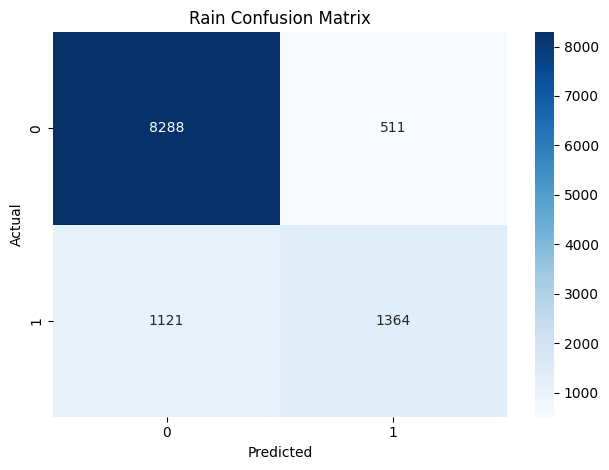

In [40]:
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

# Set the title and labels
plt.title('Rain Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()